In [1]:
%load_ext autoreload
%autoreload 2

In [174]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras import backend as K


from helper_functions import load_and_split_data
from helper_functions import triplet_loss_l2
from helper_functions import triplet_loss_cosine
from helper_functions import plot_triplet_roc_curve

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

In [4]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_15000_rgb_triplet.npz", "npz_datasets/data_y_15000_rgb_triplet.npz", split_size=80, batch_size=128, triplet=True)

CPU times: user 1min 19s, sys: 19 s, total: 1min 38s
Wall time: 1min 37s


In [5]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), (None, 0)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

In [6]:
img_width = 224
img_height = 224

In [33]:
#Set seed
tf.random.set_seed(42)

emb_size = 128

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(emb_size, activation="relu")(x)
outputs = keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(x)

base_model_vgg_16 = keras.models.Model(inputs, outputs)

In [34]:
input_anchor = keras.layers.Input(shape=(224,224,3))
input_positive = keras.layers.Input(shape=(224,224,3))
input_negative = keras.layers.Input(shape=(224,224,3))

embed_anchor = base_model_vgg_16(input_anchor)
embed_positive = base_model_vgg_16(input_positive)
embed_negative = base_model_vgg_16(input_negative)

out = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)

In [35]:
model_vgg_16 = keras.models.Model([input_anchor, input_positive, input_negative], out)

In [36]:
model_vgg_16.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")

In [ ]:
history_model_vgg_16 = model_vgg_16.fit(train_dataset, validation_data=val_dataset, epochs=20)

In [38]:
results = model_vgg_16.predict(test_dataset)

In [25]:
cosine_similarity = metrics.CosineSimilarity()

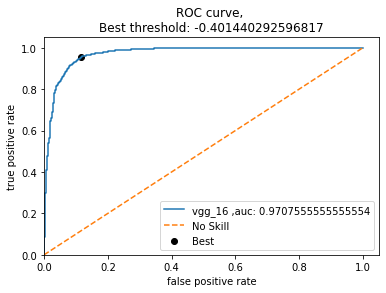

In [175]:
plot_triplet_roc_curve(model_vgg_16, test_dataset, "vgg_16", emb_size)